# 1. Credit Card Fraud Detection Intuitions

## What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

## Three challenges surrounding credit card fraud

1. It's not always easy to agree on ground truth for what "fraud" means.
2. Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
3. Most merchants aren't experts at evaluating the business impact of fraud.

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.


## Observations
- Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of `492` frauds in a total of `284,807` observations. This resulted in only `0.172%` fraud cases. This skewed set is justified by the low number of fraudulent transactions.
- The dataset consists of numerical values from the `28` ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
- The ‘Time’ and ‘Amount’ features are not transformed data.
- There is no missing value in the dataset.

## Why does class imbalanced affect model performance?

- In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
- This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

## What is the catch?
- Training a model on a balanced dataset optimizes performance on validation data.
- However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
- One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

## Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: `Time`, `Amount`
1. How different is the amount of money used in different transaction classes?
2. Do fraudulent transactions occur more often during a certain frames?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. Exploratory Data Analysis


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset

In [5]:
data.isnull().sum().sum()

0

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- `Time`
- `Amount`
- `Class` (1: fraud, 0: not_fraud)

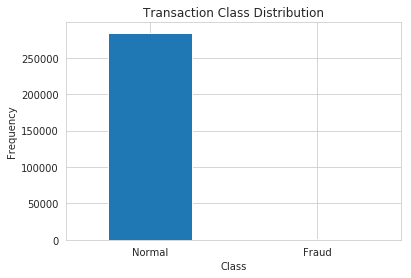

In [7]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Determine the number of fraud and valid transactions in the entire dataset.

In [9]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [10]:
print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


How different are the amount of money used in different transaction classes?

In [11]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


Do fraudulent transactions occur more often during certain time frame ?

In [12]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


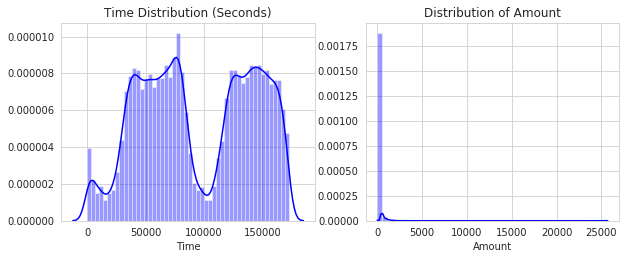

In [13]:
# plot the time feature
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.distplot(data['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.distplot(data['Amount'],color='blue');

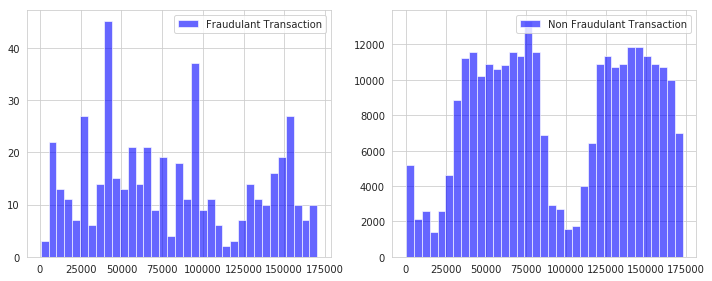

In [14]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

Doesn't seem like the time of transaction really matters here as per above observation.
Now let us take a sample of the dataset for out modelling and prediction

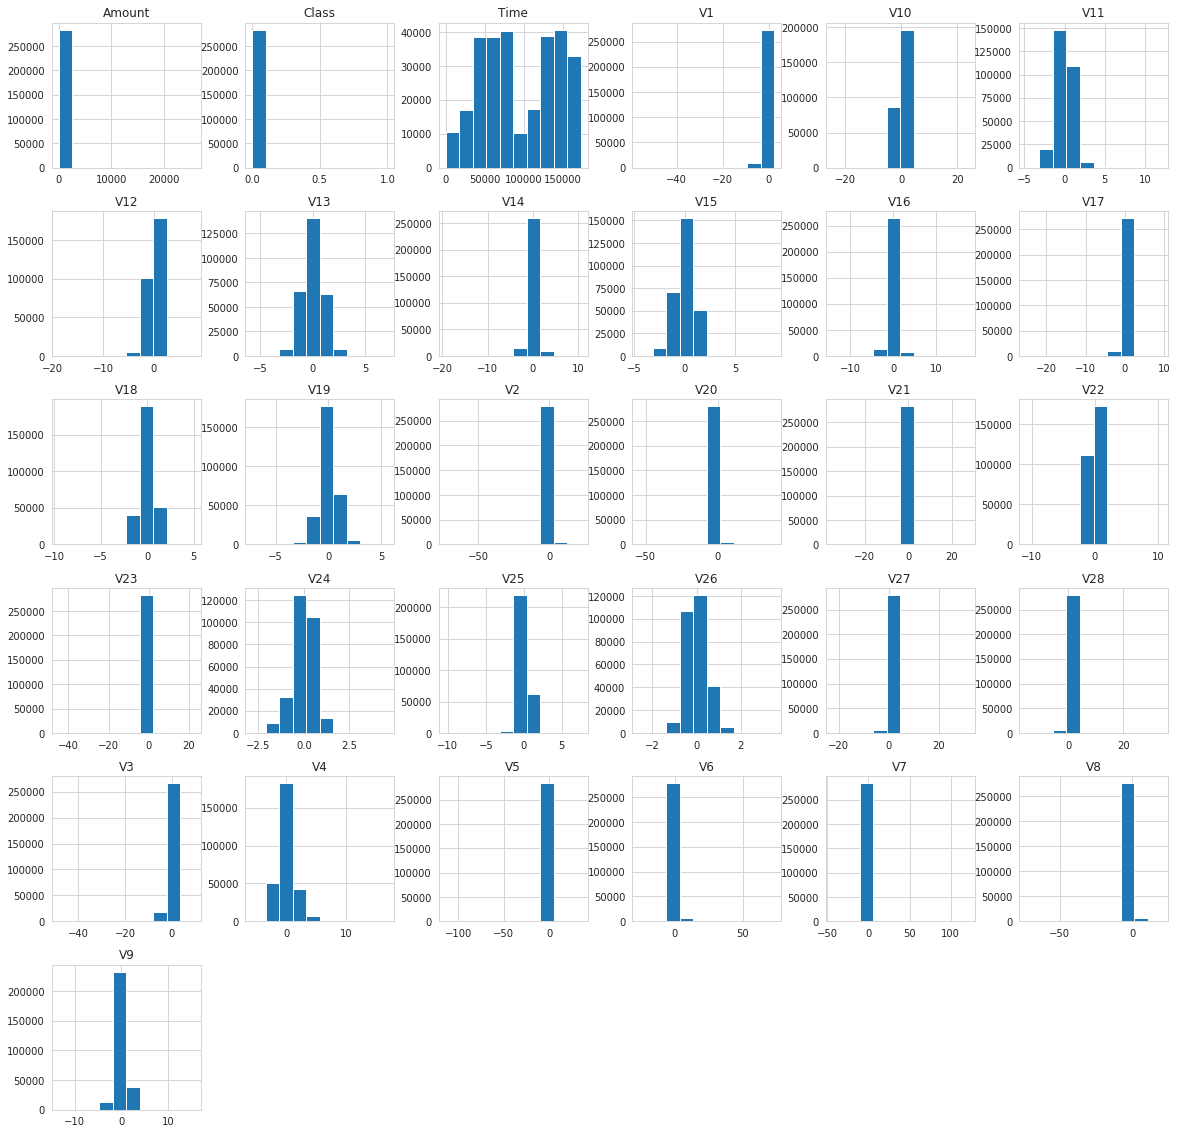

In [15]:
data.hist(figsize=(20, 20));

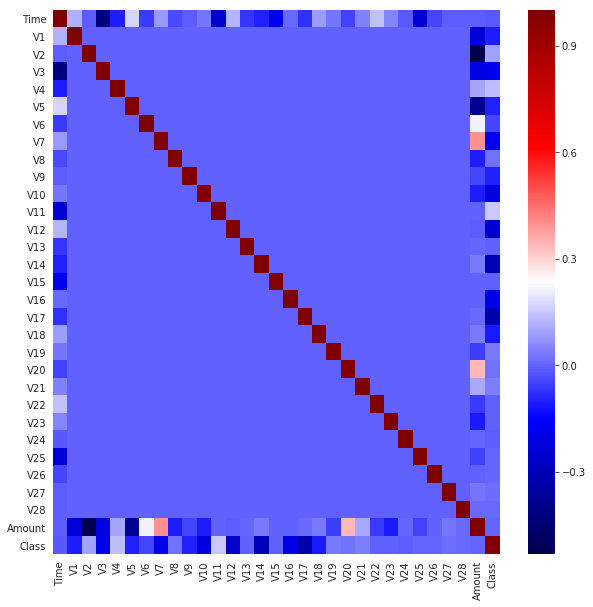

In [16]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

### Highest correlations come from:
    - Time & V3 (-0.42)
    - Amount & V2 (-0.53)
    - Amount & V4 (0.4)

- While these correlations are high, I don't expect it to run the risk of multicollinearity.

- The correlation matrix shows also that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.

# 3. Data Pre-processing

`Time` and `Amount` should be scaled as the other columns.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017994745785028623
Non-Fraudulant transaction weight: 0.9982005254214972


In [18]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

# 4. Model Building
# 4. 1. Convolutional Neural Network (CNNs)

In [20]:
X_train_d = np.expand_dims(X_train, -1)
X_test_d = np.expand_dims(X_test, -1)
X_validate_d = np.expand_dims(X_validate, -1)

In [21]:
print(f"TRAINING: X_train: {X_train_d.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate_d.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test_d.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30, 1), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30, 1), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30, 1), y_test: (85443,)


In [22]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [23]:
epochs = 10
batch = 16
weights = {0:w_n, 1:w_p}

model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=X_train_d[0].shape))
model.add(BatchNormalization())
# model.add(Dropout(0.1))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Conv1D(128, 2, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 64)            256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 128)           512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)             

In [25]:
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
r = model.fit(X_train_d, y_train, 
              validation_data=(X_validate_d, y_validate),
              batch_size=batch, 
              epochs=epochs, 
              class_weight=weights
             )

Train on 159491 samples, validate on 39873 samples
Epoch 1/10
159491/159491 [==============================] - 95s 596us/step - loss: 0.0787 - accuracy: 0.9303 - precision: 0.0211 - recall: 0.8328 - val_loss: 25.8223 - val_accuracy: 0.9004 - val_precision: 0.0142 - val_recall: 0.8261
Epoch 2/10
159491/159491 [==============================] - 91s 570us/step - loss: 0.1829 - accuracy: 0.9406 - precision: 0.0258 - recall: 0.8711 - val_loss: 52.2603 - val_accuracy: 0.8701 - val_precision: 0.0122 - val_recall: 0.9275
Epoch 3/10
159491/159491 [==============================] - 88s 553us/step - loss: 0.2136 - accuracy: 0.9317 - precision: 0.0229 - recall: 0.8885 - val_loss: 46.1701 - val_accuracy: 0.9136 - val_precision: 0.0158 - val_recall: 0.7971
Epoch 4/10
159491/159491 [==============================] - 92s 579us/step - loss: 0.2871 - accuracy: 0.9343 - precision: 0.0240 - recall: 0.8955 - val_loss: 90.4251 - val_accuracy: 0.8475 - val_precision: 0.0074 - val_recall: 0.6522
Epoch 5/10
15

In [26]:
score = model.evaluate(X_test_d, y_test)
print(score)

85443/85443 [==============================] - 8s 92us/step
[5.843886070652525, 0.9864822030067444, 0.06190885603427887, 0.529411792755127]


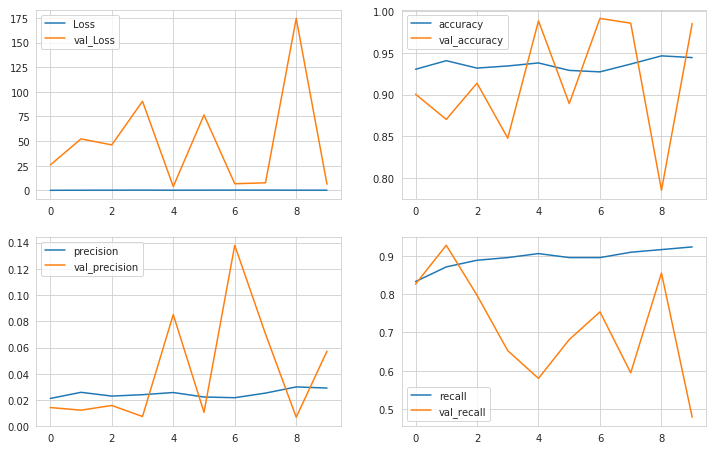

In [27]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.legend()

In [28]:
y_train_pred = model.predict(X_train_d)
y_test_pred = model.predict(X_test_d)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'CNNs_1': {
        'Train': accuracy_score(y_train, y_train_pred.round()),
        'Test': accuracy_score(y_test, y_test_pred.round()),
    },
}

Train Result:
Accuracy Score: 98.64%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   0.08      0.99       0.54          1.00
recall         0.99   0.59      0.99       0.79          0.99
f1-score       0.99   0.13      0.99       0.56          0.99
support   159204.00 287.00      0.99  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[157154   2050]
 [   119    168]]

Test Result:
Accuracy Score: 98.65%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.06      0.99       0.53          1.00
recall        0.99   0.53      0.99       0.76          0.99
f1-score      0.99   0.11      0.99       0.55          0.99
support   85307.00 136.00      0.99   85443.00      85443.00
_______________________________________________
Confusion Matrix: 

## Adding MaxPooling

In [29]:
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape=X_train_d[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(64, 2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r = model.fit(X_train_d, y_train, 
              validation_data=(X_validate_d, y_validate),
              batch_size=batch, 
              epochs=epochs, 
              class_weight=weights
             )

Train on 159491 samples, validate on 39873 samples
Epoch 1/10
159491/159491 [==============================] - 87s 549us/step - loss: 0.0048 - accuracy: 0.8709 - val_loss: 0.3578 - val_accuracy: 0.9302
Epoch 2/10
159491/159491 [==============================] - 86s 539us/step - loss: 0.0036 - accuracy: 0.8922 - val_loss: 0.4274 - val_accuracy: 0.9497
Epoch 3/10
159491/159491 [==============================] - 87s 542us/step - loss: 0.0050 - accuracy: 0.9027 - val_loss: 0.6959 - val_accuracy: 0.9477
Epoch 4/10
159491/159491 [==============================] - 84s 529us/step - loss: 0.0047 - accuracy: 0.9178 - val_loss: 0.2709 - val_accuracy: 0.9750
Epoch 5/10
159491/159491 [==============================] - 85s 532us/step - loss: 0.0047 - accuracy: 0.9278 - val_loss: 0.1911 - val_accuracy: 0.9779
Epoch 6/10
159491/159491 [==============================] - 87s 544us/step - loss: 0.0046 - accuracy: 0.9205 - val_loss: 0.0547 - val_accuracy: 0.9932
Epoch 7/10
159491/159491 [=================

In [30]:
score = model.evaluate(X_test_d, y_test)
print(score)

85443/85443 [==============================] - 7s 78us/step
[0.08172650043123476, 0.9869503378868103]


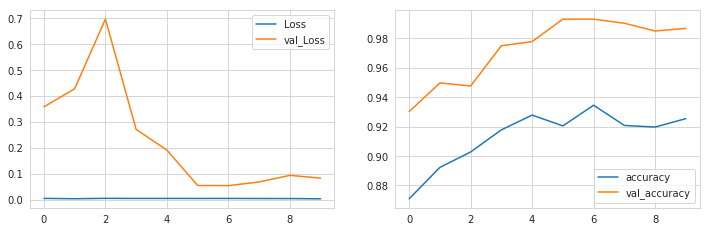

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [32]:
y_train_pred = model.predict(X_train_d)
y_test_pred = model.predict(X_test_d)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict['CNNs_2'] = {
        'Train': accuracy_score(y_train,y_train_pred.round()),
        'Test': accuracy_score(y_test, y_test_pred.round()),
    }

Train Result:
Accuracy Score: 98.68%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   0.11      0.99       0.55          1.00
recall         0.99   0.86      0.99       0.92          0.99
f1-score       0.99   0.19      0.99       0.59          0.99
support   159204.00 287.00      0.99  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[157142   2062]
 [    40    247]]

Test Result:
Accuracy Score: 98.70%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.10      0.99       0.55          1.00
recall        0.99   0.88      0.99       0.93          0.99
f1-score      0.99   0.18      0.99       0.58          0.99
support   85307.00 136.00      0.99   85443.00      85443.00
_______________________________________________
Confusion Matrix: 

# 4. 2. XGBoost

In [33]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['XGBoost'] = {
        'Train': accuracy_score(y_train,y_train_pred),
        'Test': accuracy_score(y_test, y_test_pred),
    }

Train Result:
Accuracy Score: 99.97%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   0.98      1.00       0.99          1.00
recall         1.00   0.84      1.00       0.92          1.00
f1-score       1.00   0.91      1.00       0.95          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159200      4]
 [    46    241]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.93      1.00       0.97          1.00
recall        1.00   0.82      1.00       0.91          1.00
f1-score      1.00   0.87      1.00       0.94          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix: 

# 4. 3. Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000, class_weight=weights, oob_score=False)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Random Forest'] = {
        'Train': accuracy_score(y_train,y_train_pred),
        'Test': accuracy_score(y_test, y_test_pred),
    }

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                  0      1  accuracy  macro avg  weighted avg
precision      1.00   1.00      1.00       1.00          1.00
recall         1.00   1.00      1.00       1.00          1.00
f1-score       1.00   1.00      1.00       1.00          1.00
support   159204.00 287.00      1.00  159491.00     159491.00
_______________________________________________
Confusion Matrix: 
 [[159204      0]
 [     0    287]]

Test Result:
Accuracy Score: 99.96%
_______________________________________________
Classification Report:
                 0      1  accuracy  macro avg  weighted avg
precision     1.00   0.96      1.00       0.98          1.00
recall        1.00   0.79      1.00       0.90          1.00
f1-score      1.00   0.87      1.00       0.94          1.00
support   85307.00 136.00      1.00   85443.00      85443.00
_______________________________________________
Confusion Matrix:

# 5. Model Comparaison

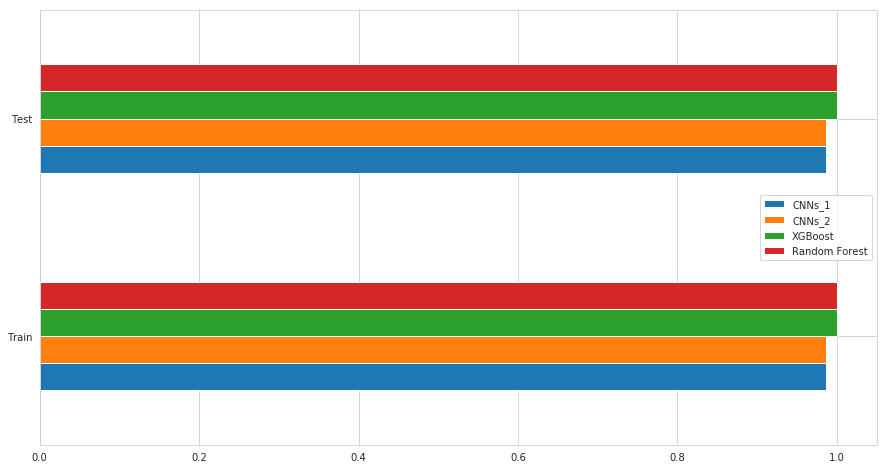

In [35]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(15, 8))